In [1]:

import torch
import numpy as np
%matplotlib inline  
import matplotlib.pyplot as plt
from IPython.display import HTML, display, clear_output
from tqdm.notebook import tqdm

In [2]:
# Options are: 'Gaussian', 'Square', 'Heart', 'Spiral', 'Two Gaussians', 'Smiley'
source_data_choice = 'Gaussian'
target_data_choice = 'Spiral'       

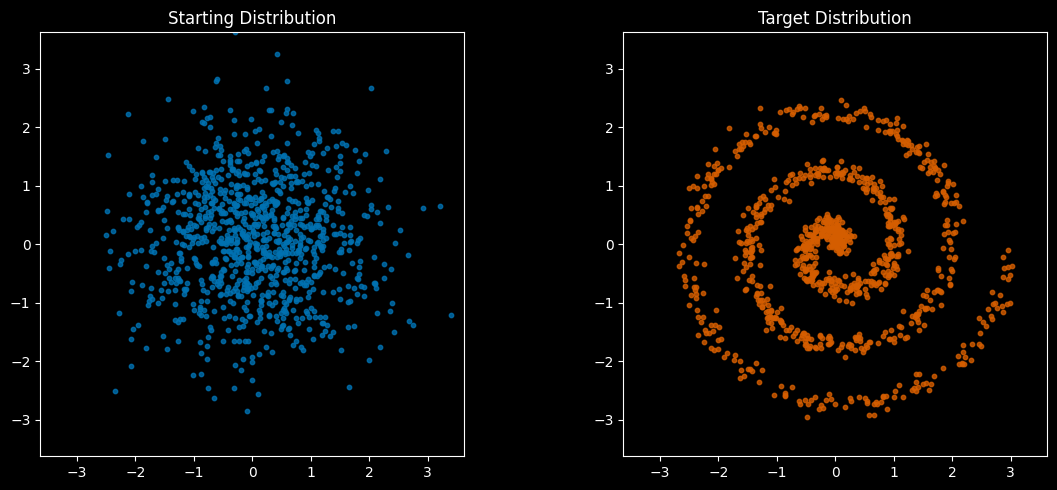

In [3]:
# for accessibility: Wong's color pallette: cf. https://davidmathlogic.com/colorblind
#wong_black = [0/255, 0/255, 0/255]          # #000000
wong_amber = [230/255, 159/255, 0/255]      # #E69F00
wong_cyan = [86/255, 180/255, 233/255]      # #56B4E9
wong_green = [0/255, 158/255, 115/255]      # #009E73
wong_yellow = [240/255, 228/255, 66/255]    # #F0E442
wong_navy = [0/255, 114/255, 178/255]       # #0072B2
wong_red = [213/255, 94/255, 0/255]         # #D55E00
wong_pink = [204/255, 121/255, 167/255]     # #CC79A7
wong_cmap = [wong_amber, wong_cyan, wong_green, wong_yellow, wong_navy, wong_red, wong_pink]

source_color = wong_navy
target_color = wong_red
pred_color = wong_green
line_color = wong_yellow
bg_theme = 'dark' #  'black', 'white', 'dark', 'light'
if bg_theme in ['black','dark']:
    plt.style.use('dark_background')
else:
    plt.rcdefaults()
    

# A few different data distributions
def create_gaussian_data(n_points=1000, scale=1.0):
    """Create a 2D Gaussian distribution"""
    return torch.randn(n_points, 2) * scale

def create_square_data(n_points=1000, scale=3.0):  # 3 is set by the spread of the gaussian and spiral 
    """Create points uniformly distributed in a square"""
    # Generate uniform points in a square
    points = (torch.rand(n_points, 2) * 2 - 1) * scale
    return points
 
def create_spiral_data(n_points=1000, scale=1):
    """Create a spiral distribution. i like this one more"""
    noise = 0.1*scale 
    #theta = torch.linspace(0, 6*np.pi, n_points) # preferred order? no way
    theta = 6*np.pi* torch.rand(n_points)
    r = theta / (2*np.pi) * scale
    x = r * torch.cos(theta) + noise * torch.randn(n_points)
    y = r * torch.sin(theta) + noise * torch.randn(n_points)
    return torch.stack([x, y], dim=1)

def create_heart_data(n_points=1000, scale=3.0):
    """Create a heart-shaped distribution of points"""
    square_points = create_square_data(n_points, scale=1.0)
    
    # Calculate the heart-shaped condition for each point
    x, y = square_points[:, 0], square_points[:, 1]
    heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
    
    # Filter out points that don't satisfy the heart-shaped condition
    heart_points = square_points[heart_condition]
    
    # If we don't have enough points, generate more
    while len(heart_points) < n_points:
        new_points = create_square_data(n_points - len(heart_points), scale=1)
        x, y = new_points[:, 0], new_points[:, 1]
        new_heart_condition = x**2 + ((5 * (y + 0.25) / 4) - torch.sqrt(torch.abs(x)))**2 <= 1
        new_heart_points = new_points[new_heart_condition]
        heart_points = torch.cat([heart_points, new_heart_points], dim=0)

    heart_points *= scale 
    return heart_points[:n_points]

def create_two_gaussians_data(n_points=1000, scale=1.0, shift=2.5):
    """Create a 2D Gaussian distribution"""
    g  = torch.randn(n_points, 2) * scale
    g[:n_points//2,0] -= shift
    g[n_points//2:,0] += shift
    indices = torch.randperm(n_points)
    return g[indices]


def create_smiley_data(n_points=1000, scale=2.5):
    "make a smiley face"
    points = []
    # Face circle -- Meh, IDK if the outer circle adds much TBH
    #angles = 2 * np.pi * torch.rand(n_points//2+20)
    #r = scale + (scale/10)*torch.sqrt(torch.rand(n_points//2+20)) 
    #points.append(torch.stack([r * torch.cos(angles), r * torch.sin(angles)], dim=1))
    
    # Eyes (small circles at fixed positions)
    for eye_pos in [[-1, 0.9], [1, 0.9]]:
        eye = torch.randn(n_points//3+20, 2) * 0.2 + torch.tensor(eye_pos) * scale * 0.4
        points.append(eye)
        
    # Smile (arc in polar coordinates)
    theta = -np.pi/6 - 2*np.pi/3*torch.rand(n_points//3+20) 
    r_smile = scale * 0.6 + (scale/4)* torch.rand_like(theta)
    points.append(torch.stack([r_smile * torch.cos(theta), r_smile * torch.sin(theta)], dim=1))
    
    points = torch.cat(points, dim=0)  # concatenate first
    points = points[torch.randperm(points.shape[0])]  # then shuffle
    return points[:n_points,:]
    

# Initialize generator functions
source_gen_fn = None
target_gen_fn = None

# Assign generator functions based on user choices
for gen_choice, gen_fn_name in zip([source_data_choice, target_data_choice], ['source_gen_fn', 'target_gen_fn']):
    gen_choice = gen_choice.lower()
    if 'two gaussians' in gen_choice:
        gen_fn = create_two_gaussians_data
    elif 'heart' in gen_choice:
        gen_fn = create_heart_data
    elif 'spiral' in gen_choice:
        gen_fn = create_spiral_data
    elif 'square' in gen_choice:
        gen_fn = create_square_data
    elif 'smiley' in gen_choice:
        gen_fn = create_smiley_data
    else:
        gen_fn = create_gaussian_data
    
    if gen_fn_name == 'source_gen_fn':
        source_gen_fn = gen_fn
    else:
        target_gen_fn = gen_fn
        
# A couple aliases so we can easily switch distributions without affecting later code 
def create_source_data(n_points=1000, hshift=0):  # hshift can make it a bit easier to see trajectories later
    g = source_gen_fn(n_points=n_points)
    if hshift != 0: g[:,0] += hshift
    return g
    
def create_target_data(n_points=1000, hshift=0):
    g = target_gen_fn(n_points=n_points)
    if hshift != 0: g[:,0] += hshift
    return g

def plot_distributions(dist1, dist2, title1="Distribution 1", title2="Distribution 2", alpha=0.8):
    """Plot two distributions side by side"""
    plt.close('all')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    ax1.scatter(dist1[:, 0], dist1[:, 1], alpha=alpha, s=10, color=source_color)
    ax2.scatter(dist2[:, 0], dist2[:, 1], alpha=alpha, s=10, color=target_color)
    
    ax1.set_title(title1)
    ax2.set_title(title2)
    
    # Set same scale for both plots
    max_range = max(
        abs(dist1).max().item(),
        abs(dist2).max().item()
    )
    for ax in [ax1, ax2]:
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()  # Explicitly show the plot
    plt.close()



def interpolate_color(t, start='blue', end='red'):
    """Interpolate from start color to end color"""
    start_color = plt.cm.colors.to_rgb(start)
    end_color = plt.cm.colors.to_rgb(end)
    return (1-t) * np.array(start_color) + t * np.array(end_color)


def show_flow_sequence(start_dist, end_dist, n_steps=5, c_start=source_color, c_end=target_color):
    """Show the flow as a sequence of static plots"""
    fig, axes = plt.subplots(1, n_steps, figsize=(4*n_steps, 4))
    
    max_range = max(
        abs(start_dist).max().item(),
        abs(end_dist).max().item()
    )
    
    for i, ax in enumerate(axes):
        t = i / (n_steps - 1)
        current = start_dist * (1-t) + end_dist * t
        
        color = interpolate_color(t, start=c_start, end=c_end)
        ax.scatter(current[:, 0], current[:, 1], 
                  alpha=0.8, s=10, 
                  c=[color])
        
        ax.set_xlim(-max_range, max_range)
        ax.set_ylim(-max_range, max_range)
        ax.set_aspect('equal')
        ax.set_title(f't = {t:.2f}')
    
    plt.tight_layout()
    plt.show()
    plt.close()



# Create our distributions and look at them
n_points = 1000
source, target = create_source_data(n_points), create_target_data(n_points)

plot_distributions(source, target, "Starting Distribution", "Target Distribution")

In [4]:
import os 

source_L = source.clone()
shift = 5
source_L[:,0] -= shift
target_R = target.clone()
target_R[:,0] += shift  # Note: fixed the indexing here from [:0] to [:,0]

fig, ax = plt.subplots(figsize=(8,4))
# show the whole distribution
ax.scatter(source_L[:,0], source_L[:,1], color=source_color, alpha=0.5)
ax.scatter(target_R[:,0], target_R[:,1], color=target_color, alpha=0.5)

# Draw lines connecting points, with source & target points outlined
n_lines = 15
ax.scatter(source_L[:n_lines,0], source_L[:n_lines,1], color=source_color, alpha=0.5, 
           facecolor='none', edgecolor=line_color,)
ax.scatter(target_R[:n_lines,0], target_R[:n_lines,1], color=target_color, alpha=0.5,
           facecolor='none', edgecolor=line_color,)
for i in range(n_lines):
    ax.plot([source_L[i,0], target_R[i,0]], 
        [source_L[i,1], target_R[i,1]], 
        '-', alpha=0.3, color=line_color+[.9], 
        linewidth=2)  # or lw=2

ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
for [x, label] in zip([-shift,shift], ['Source','Target']):
    ax.text(x, 4, label, fontsize=12, color='black', ha='center',  va='center',)
#plt.show()
os.makedirs('images', exist_ok=True) 
save_file='images/gaussian_to_spiral_crossing_lines.png'
plt.savefig(save_file)
#plt.show()
plt.close()

HTML(f"""<center><img src="{save_file}" width="600"></center>""") 

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import torch
import pandas as pd

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

def rgb_to_plotly(rgb):
    # Convert [r, g, b] where r,g,b are 0-1 to 'rgb(r,g,b)' where r,g,b are 0-255
    return f'rgb({int(rgb[0]*255)},{int(rgb[1]*255)},{int(rgb[2]*255)})'

def plot_3d_lines():
    # Set theme based on bg_theme
    if bg_theme in ['black', 'dark']:
        template = "plotly_dark"
    else:
        template = "plotly_white"
    
    # Convert source and target to DataFrames for Plotly Express
    source_df = pd.DataFrame({
        'x': source[:,0].numpy(),
        'y': source[:,1].numpy(),
        'z': np.zeros(len(source)),
        'distribution': ['Source'] * len(source)
    })
    
    target_df = pd.DataFrame({
        'x': target[:,0].numpy(),
        'y': target[:,1].numpy(),
        'z': np.ones(len(target)),
        'distribution': ['Target'] * len(target)
    })
    
    # Combine dataframes
    points_df = pd.concat([source_df, target_df], ignore_index=True)
    
    # Create scatter plot for source and target points
    fig = px.scatter_3d(
        points_df,
        x='x',
        y='y',
        z='z',
        color='distribution',
        color_discrete_map={
            'Source': rgb_to_plotly(source_color),
            'Target': rgb_to_plotly(target_color)
        },
        opacity=0.5,
        size_max=3
    )
    
    # Create trajectory lines
    points_per_traj = 250
    ts = torch.linspace(0, 1, points_per_traj)
    
    for i in range(n_lines):
        source_point = source[i,:]
        target_point = target[i,:]
        
        # Manual linear interpolation
        x_vals = source_point[0] * (1-ts) + target_point[0] * ts
        y_vals = source_point[1] * (1-ts) + target_point[1] * ts
        
        # Add trajectory line
        fig.add_trace(go.Scatter3d(
            x=x_vals.numpy(),
            y=y_vals.numpy(),
            z=ts.numpy(),
            mode='lines',
            line=dict(color=rgb_to_plotly(line_color), width=2),
            opacity=0.7,
            showlegend=False
        ))
        
        # Add highlighted source and target points
        # Source point highlight
        fig.add_trace(go.Scatter3d(
            x=[source_point[0].item()],
            y=[source_point[1].item()],
            z=[0],
            mode='markers',
            marker=dict(
                color=rgb_to_plotly(line_color), 
                size=4, 
                line=dict(color=rgb_to_plotly(line_color), width=2)
            ),
            showlegend=False
        ))
        
        # Target point highlight
        fig.add_trace(go.Scatter3d(
            x=[target_point[0].item()],
            y=[target_point[1].item()],
            z=[1],
            mode='markers',
            marker=dict(
                color=rgb_to_plotly(line_color), 
                size=4, 
                line=dict(color=rgb_to_plotly(line_color), width=2)
            ),
            showlegend=False
        ))
    
    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Time",
            aspectmode='manual',
            aspectratio=dict(x=1, y=1, z=0.5),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1)
            )
        ),
        template=template,
        margin=dict(l=0, r=0, b=0, t=30),
        legend_title_text='Distribution'
    )
    
    return fig 

fig = plot_3d_lines()
fig.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class VelocityNet(nn.Module):
    def __init__(self, input_dim, h_dim=64):
        super().__init__()
        self.fc_in  = nn.Linear(input_dim + 1, h_dim)
        self.fc2    = nn.Linear(h_dim, h_dim)
        self.fc3    = nn.Linear(h_dim, h_dim)
        self.fc_out = nn.Linear(h_dim, input_dim)
    
    def forward(self, x, t, act=F.gelu):
        t = t.expand(x.size(0), 1)  # Ensure t has the correct dimensions
        x = torch.cat([x, t], dim=1)
        x = act(self.fc_in(x))
        x = act(self.fc2(x))
        x = act(self.fc3(x))
        return self.fc_out(x)

# Instantiate the model
input_dim = 2
model = VelocityNet(input_dim)

In [7]:
@torch.no_grad()
def fwd_euler_step(model, current_points, current_t, dt):
    velocity = model(current_points, current_t)
    return current_points + velocity * dt 
@torch.no_grad()
def integrate_path(model, initial_points, step_fn=fwd_euler_step, n_steps=100,
                   save_trajectories=False, warp_fn=None):
    """this 'sampling' routine is primarily used for visualization."""
    device = next(model.parameters()).device
    current_points = initial_points.clone()
    ts =  torch.linspace(0,1,n_steps).to(device)
    if warp_fn: ts = warp_fn(ts)
    if save_trajectories: trajectories = [current_points]    
    for i in range(len(ts)-1):
        current_points = step_fn(model, current_points, ts[i], ts[i+1]-ts[i])
        if save_trajectories: trajectories.append(current_points)
    if save_trajectories: return current_points, torch.stack(trajectories).cpu()
    return current_points 

generate_samples = integrate_path # just lil' alias for the probability / diffusion model crowd ;-) 

Testing visualization routines (before training):


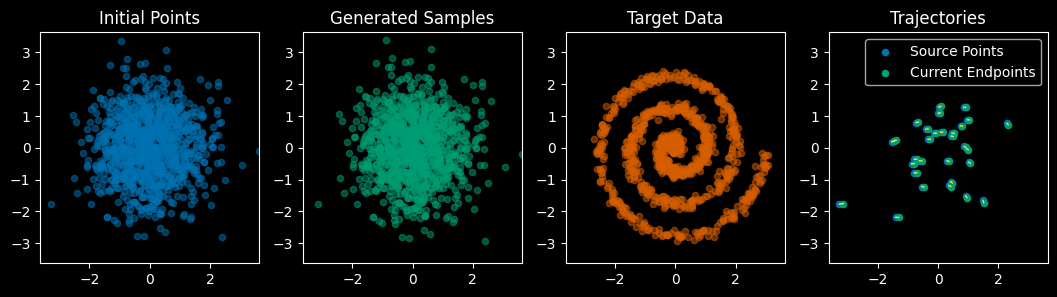

In [8]:
def viz(val_points, target_samples, trained_model, size=20, alpha=0.5, n_steps=100, warp_fn=None,):
    # Generate and visualize new samples
    device = next(trained_model.parameters()).device
    generated_samples, trajectories = integrate_path(trained_model, val_points.to(device), n_steps=n_steps, warp_fn=warp_fn, save_trajectories=True)

    n_viz = min(30, len(trajectories[0]))  # Number of trajectories to visualize
    
    fig, ax = plt.subplots(1,4, figsize=(13,3))
    data_list = [val_points.cpu(), generated_samples.cpu(), target_samples.cpu()] 
    label_list = ['Initial Points', 'Generated Samples', 'Target Data','Trajectories']
    color_list = [source_color, pred_color, target_color]
    global_max = max( torch.max(torch.abs(torch.cat(data_list)),0)[0][0],  torch.max(torch.abs(torch.cat(data_list)),0)[0][1] )
    for i in range(len(label_list)):
        ax[i].set_title(label_list[i]) 
        ax[i].set_xlim([-global_max, global_max]) 
        ax[i].set_ylim([-global_max, global_max])
        if i < 3: # non-trajectory plots
            ax[i].scatter( data_list[i][:, 0], data_list[i][:, 1], s=size, alpha=alpha, 
                          label=label_list[i], color=color_list[i])
        else:
            # Plot trajectory paths first
            for j in range(n_viz):
                path = trajectories[:, j]
                ax[3].plot(path[:, 0], path[:, 1], '-', color=line_color, alpha=1, linewidth=1)
            
            # Then plot start and end points for the SAME trajectories
            start_points = trajectories[0, :n_viz]
            end_points = trajectories[-1, :n_viz]  
            ax[3].scatter(start_points[:, 0], start_points[:, 1], color=source_color, s=size, alpha=1, label='Source Points')
            ax[3].scatter(end_points[:, 0], end_points[:, 1], color=pred_color, s=size, alpha=1, label='Current Endpoints')
            ax[3].legend()

    plt.show()
    plt.close()

# Visualize the data
n_samples = 1000
source_samples = create_source_data(n_samples)
target_samples = create_target_data(n_samples)
val_points = create_source_data(n_samples)
print("Testing visualization routines (before training):") 
viz(val_points, target_samples,  model) 

In [9]:
import torch.optim as optim

def train_model(model, n_epochs=100, lr=0.003, batch_size=2048, status_every=1, viz_every=1, warp_fn=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    step, n_steps = 0, 100
    device = next(model.parameters()).device
    
    for epoch in range(n_epochs):
        model.train()
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()
    
            # by randomly generating new data each step, we prevent the model from merely memorizing
            source_samples = create_source_data(batch_size).to(device)
            target_samples = create_target_data(batch_size).to(device)
            
            t = torch.rand(source_samples.size(0), 1).to(device)  # random times for traning
            if warp_fn: t = warp_fn(t)    # time warp is good for coverage but not as helpful for training as it is during integration/sampling
            interpolated_samples = source_samples * (1 - t) + target_samples * t
            line_directions = target_samples - source_samples
            
            drift = model(interpolated_samples, t)
            loss = loss_fn(drift, line_directions)
            
            loss.backward()
            optimizer.step()

            status_str = f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}'
            pbar.set_description(status_str)
        
        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            viz(val_points, target_samples[:val_points.shape[0]], model)
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()
            
        if epoch==n_epochs-1: print(status_str)  # keep last status from being cleared
    
    return model


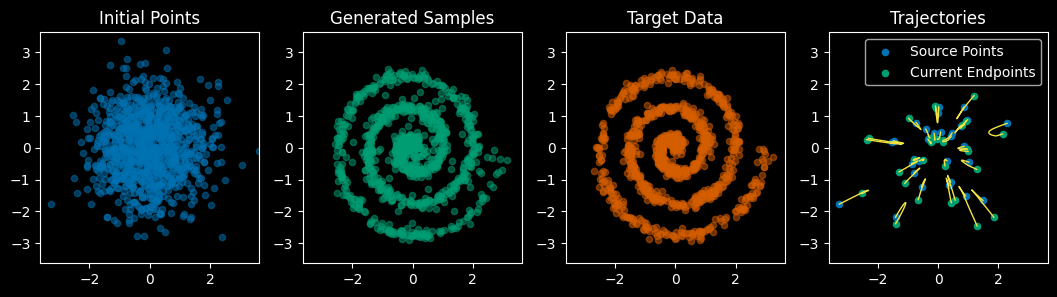

Epoch [100/100], Loss: 1.8204


In [10]:
fm_model = train_model(model, n_epochs=100)    

In [14]:
import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
from matplotlib import rc
import os

@torch.no_grad()
def create_flow_animation(start_dist, models, titles=None, figsize=None, n_frames=50,
                         step_fn=fwd_euler_step, n_steps=100, warp_fn=None, save_file=None, height=4):
    """
    Create an animation showing multiple distribution flows
    
    Args:
        start_dist: Starting distribution
        models: List of models to animate
        titles: List of titles for each subplot (optional)
        figsize: Figure size (optional)
        n_frames: Number of animation frames
        integrator: Integration function to use
        jitter: Amount of jitter to add
        save_file: Path to save animation (optional)
        height: Height of each subplot
    """
    plt.close('all')  # Close all open figures
    
    if not isinstance(models, list): models = [models]
    n_plots = len(models)
    
    if titles is None:
        titles = [f'Flow {i+1}' for i in range(n_plots)]
    elif len(titles) != n_plots:
        raise ValueError(f"Number of titles ({len(titles)}) must match number of models ({n_plots})")
    
    # Calculate figure size
    if figsize is None:
        figsize = [height * n_plots, height]
    
    # Create subplots
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    if n_plots == 1:
        axes = [axes]
    plt.close()  # Close the figure immediately

    
    # Initialize scatters and trajectories
    scatters = []
    all_trajectories = []
    
    # Generate trajectories for each model
    max_range = abs(start_dist).max().item()
    
    for i, model in enumerate(models):
        device = next(model.parameters()).device
        end_dist, trajectories = integrate_path(model, start_dist.clone().to(device), n_steps=n_frames,  
                                          step_fn=step_fn, warp_fn=warp_fn, save_trajectories=True)
        all_trajectories.append(trajectories.cpu())
        scatters.append(axes[i].scatter([], [], alpha=0.6, s=10, color=wong_pink))
        
        # Update max range
        max_range = max(max_range, abs(end_dist.cpu()).max().item())
    
    # Set up axes
    for i, ax in enumerate(axes):
        ax.set_xlim((-max_range, max_range))
        ax.set_ylim((-max_range, max_range))
        ax.set_aspect('equal')
        ax.set_xticks([])
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(False)
        ax.set_title(titles[i])
    
    def init():
        """Initialize animation"""
        for scatter in scatters:
            scatter.set_offsets(np.c_[[], []])
        return tuple(scatters)
    
    def animate(frame):
        """Update animation frame"""
        # Update axis limits (in case they need to be adjusted)
        for ax in axes:
            ax.set_xlim((-max_range, max_range))
            ax.set_ylim((-max_range, max_range))
        
        # Update scatter positions
        for scatter, trajectories in zip(scatters, all_trajectories):
            scatter.set_offsets(trajectories[frame].numpy())
        
        return tuple(scatters)
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=n_frames, interval=20, blit=True)
    
    # Handle saving or displaying
    if save_file:
        os.makedirs(os.path.dirname(save_file), exist_ok=True)
        anim.save(save_file, writer='ffmpeg', fps=30)
        return HTML(f"""<center><video height="350" controls loop><source src="{anim_file}" type="video/mp4">
              Your browser does not support the video tag. </video></center>""")
    else:  # direct matplotlib anim offers better controls but makes ipynb file size huge
        rc('animation', html='jshtml')
        return HTML(anim.to_jshtml())
    plt.close()



anim_file = 'images/particles_fm.mp4'
create_flow_animation(val_points.clone(), models=[fm_model], titles=['Flow Matching'],
                      n_frames=50, save_file=anim_file)

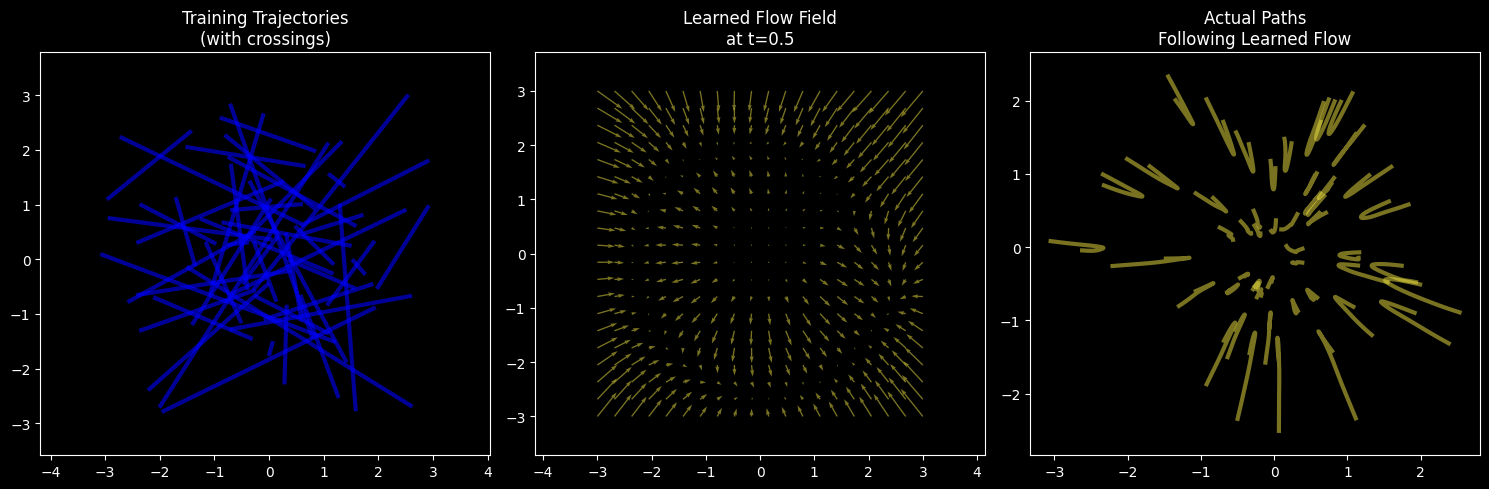

In [15]:
@torch.no_grad()
def plot_training_trajectories_vs_learned_flow(model):
   """Compare training trajectories with learned flow field"""
   plt.figure(figsize=(15, 5))
   
   # 1. Plot some training trajectories
   plt.subplot(131)
   n_trajs = 50  # Number of trajectories to show
   device = next(model.parameters()).device
   source = create_gaussian_data(n_trajs)
   target = create_square_data(n_trajs)
   current_points = source.clone().to(device)

   
   # Plot straight-line trajectories from source to target
   times = torch.linspace(0, 1, 20)
   for i in range(n_trajs):
       traj = source[i:i+1] * (1 - times.reshape(-1, 1)) + target[i:i+1] * times.reshape(-1, 1)
       plt.plot(traj[:, 0], traj[:, 1], 'b-', alpha=0.6, linewidth=3)
   plt.title('Training Trajectories\n(with crossings)')
   plt.axis('equal')
   
   # 2. Plot learned flow field
   plt.subplot(132)
   x = torch.linspace(-3, 3, 20)
   y = torch.linspace(-3, 3, 20)
   X, Y = torch.meshgrid(x, y, indexing='ij')
   points = torch.stack([X.flatten(), Y.flatten()], dim=1).to(device)
   
   # with torch.no_grad():
   #     t =  0.5  # Show flow field at t=0.5
   #     ones = torch.ones(points.size(0), 1)

   ones = torch.ones(points.size(0), 1).to(device)
   t = ones * (0.5)
   velocities = model(points, t).cpu()
   #print("points.shape, ones.shape = ",points.shape, ones.shape) 
   #velocities = model(points, t*ones)
   points = points.cpu()
   plt.quiver(points[:, 0], points[:, 1], 
             velocities[:, 0], velocities[:, 1],
             alpha=0.5, color=line_color, linewidth=3)
   plt.title('Learned Flow Field\nat t=0.5')
   plt.axis('equal')
   
   # 3. Plot actual paths taken using learned flow
   plt.subplot(133)
   source = create_gaussian_data(n_trajs)
   
   # Use RK4 to follow the learned flow
   paths = []
   n_steps = 20
   dt = 1.0 / n_steps
   
   with torch.no_grad():
       ones = torch.ones(current_points.size(0), 1).to(device)
       for i in range(n_steps):
           paths.append(current_points.clone())
           
           # RK4 step
           t = ones * (i * dt)
           k1 = model(current_points, t)
           k2 = model(current_points + k1 * dt/2, t + dt/2)
           k3 = model(current_points + k2 * dt/2, t + dt/2)
           k4 = model(current_points + k3 * dt, t + dt)
           
           current_points = current_points + (k1 + 2*k2 + 2*k3 + k4) * dt/6
   
   paths = torch.stack(paths).cpu()
   
   # Plot the actual paths
   for i in range(n_trajs):
       traj = paths[:, i, :]
       plt.plot(traj[:, 0], traj[:, 1], color=line_color, alpha=0.5, linewidth=3)
   plt.title('Actual Paths\nFollowing Learned Flow')
   plt.axis('equal')
   
   plt.tight_layout()
   plt.savefig('images/cross_uncross_plot.png')
   plt.show()
   plt.close()

# Run the visualization
plot_training_trajectories_vs_learned_flow(fm_model)

In [16]:
def warp_time(t, dt=None, s=.5):
    """Parametric Time Warping: s = slope in the middle. 
        s=1 is linear time, s < 1 goes slower near the middle, s>1 goes slower near the ends
        s = 1.5 gets very close to the "cosine schedule", i.e. (1-cos(pi*t))/2, i.e. sin^2(pi/2*x)"""
    if s<0 or s>1.5: raise ValueError(f"s={s} is out of bounds.")
    tw = 4*(1-s)*t**3 + 6*(s-1)*t**2 + (3-2*s)*t 
    if dt:                           # warped time-step requested; use derivative
        return tw,  dt * 12*(1-s)*t**2 + 12*(s-1)*t + (3-2*s) 
    return tw

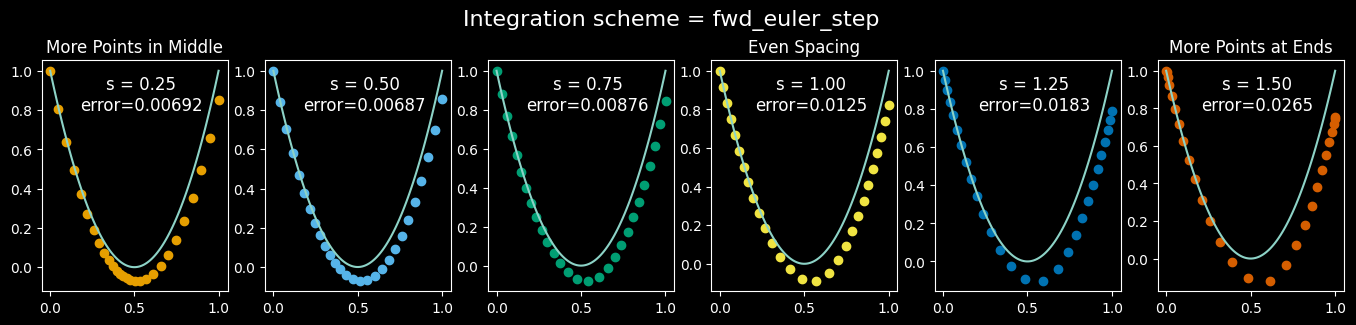

In [17]:
from functools import partial 

parab   = lambda x: 4*(x-0.5)**2  # curve shape
d_parab = lambda x: 8*(x-0.5)     # derivative
ds      = lambda x: torch.sqrt(1 + d_parab(x)**2)  # differential arc length

def calculate_total_arc_length(n=1000):
    """Calculate the total arc length of the parabola y = 4(x - 0.5)**2 from x=0 to x=1"""
    x_values = torch.linspace(0, 1, n)
    arc_length_values = ds(x_values)
    total_arc_length = torch.trapz(arc_length_values, x_values)
    return total_arc_length

def fake_velocity_model(loc, t, speed=1.0):
    """For demo purposes only: Follow a parabolic path and move at unit speed
    Compute the x and y components of the velocity along the parabola y = 4(x - 0.5)^2"""
    x, y = loc[:, 0], loc[:, 1]    
    slope = d_parab(x)
    direction = torch.stack([torch.ones_like(slope), slope], dim=1)    
    magnitude = torch.norm(direction, dim=1, keepdim=True)
    unit_velocity = direction / magnitude    
    return unit_velocity*speed

@torch.no_grad()
def integrate_motion_along_parabola(
        model, initial_points, n_steps=30, step_fn=fwd_euler_step, s=0.5,):
    """one-off integrator used only for this one visualization figure. don't use for anything else"""
    current_points = initial_points.clone()
    trajectories = [current_points.cpu().clone()]
    ts = torch.linspace(0,1.0, n_steps) 
    ts = warp_time(ts, s=s)                # here's the time worpage
    speed = calculate_total_arc_length()   # Total travel time is 1.0 so speed "=" distance
    scaled_model = partial(model, speed=speed)
    with torch.no_grad():
        for i in range(n_steps-1):
            current_points = step_fn( scaled_model , current_points.clone(), ts[i],  ts[i+1]-ts[i])
            trajectories.append(current_points.cpu().clone())
    return torch.stack(trajectories)

@torch.no_grad()
def viz_parabola_with_steps(step_fn=fwd_euler_step, n_steps=28):
    """varies warp parameter s and integrates along a parabola"""
    plt.close()
    t_curve = torch.linspace(0,1,100)

    n_t_points = n_steps # 28 if step_fn==fwd_euler_step else 6
    t_points = torch.linspace(0,1,n_t_points)

    n_s = 6    # number of different s values to show
    fig, ax = plt.subplots(1, n_s, figsize=(n_s*2.8, 3))
    plt.suptitle(f"Integration scheme = {step_fn.__name__}", fontsize=16, y=1.05)
    initial_points = torch.tensor([[0,1]])                   # one point in the top left
    for i, s in enumerate(torch.linspace(.25, 1.5, n_s)):   # warp time by different amounts via s parameter
        ax[i].plot(t_curve, parab(t_curve))    # solid line showing path
        traj = integrate_motion_along_parabola(fake_velocity_model, initial_points, n_steps=n_t_points, 
                    s=s, step_fn=step_fn).squeeze() 
        err_str = f"\nerror={F.mse_loss(parab(traj[:,0]),traj[:,1]):.3g}"
        ax[i].scatter(traj[:,0], traj[:,1], label=f's = {s:.2f}{err_str}', color=(wong_cmap*2)[i])

        legend = ax[i].legend(loc='upper center', frameon=False, markerscale=0, handlelength=0, fontsize=12)
        for text in legend.get_texts():
            text.set_ha('center')

        if abs(s-1.0) < 1e-3: ax[i].set_title('Even Spacing') 
            
    ax[0].set_title('More Points in Middle')
    ax[-1].set_title('More Points at Ends')
    plt.show()
    plt.close()

viz_parabola_with_steps() 

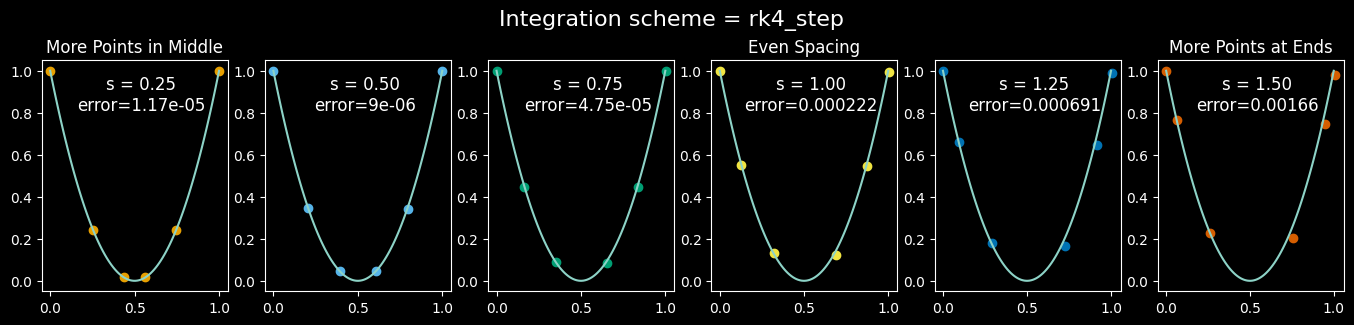

In [18]:
def rk4_step(f, # function that takes (y,t) and returns dy/dt, i.e. velocity
             y, # current location
             t, # current t value
             dt, # requested time step size 
             ):
    k1 =  f(y, t)
    k2 =  f(y + dt*k1/2, t + dt/2) 
    k3 =  f(y + dt*k2/2, t + dt/2) 
    k4 =  f(y + dt*k3, t + dt) 
    return y + (dt/6)*(k1 + 2*k2 + 2*k3 + k4)

viz_parabola_with_steps(step_fn=rk4_step, n_steps=6) 

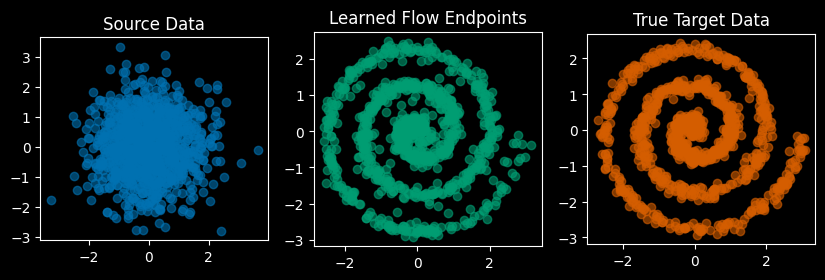

In [20]:
pretrained_model = fm_model 
pretrained_model.eval()
reflow_targets = integrate_path(pretrained_model, val_points.to(), n_steps=8, step_fn=rk4_step, warp_fn=warp_time).cpu()

fig, ax = plt.subplots(1,3, figsize=(10,3))
for i, [data, color, label] in enumerate(zip([val_points,   reflow_targets, target_samples], 
                                             [source_color, pred_color,     target_color],
                                             ['Source Data', 'Learned Flow Endpoints', 'True Target Data'])):
    ax[i].scatter(data[:,0], data[:,1], color=color, label=label, alpha=0.6)
    ax[i].set_aspect('equal')
    ax[i].set_title(label)
plt.show()
plt.close()

In [22]:
def train_reflow_model(model, pretrained_model=None, 
                          n_epochs=40, lr=0.001, batch_size=2048, 
                          status_every=1, viz_every=1, # in epochs
                          new_points_every=1, # in steps 
                          warp_fn=warp_time, 
                          step_fn=rk4_step, # rk4 so we get high-quality outputs while reflowing
                          ):
    """This is almost IDENTICAL to the previous training routine. 
        The difference is the change in "target_samples" via what the RF authors call "ReFlow": 
        Instead of (randomly) paring source points with points in the "true target distribution", 
        we use the pretrained/teacher model to integrate the source points to their (predicted) flow endpoints 
        and use THOSE as the "target" values.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    step, n_steps = 0, 100
    device = next(model.parameters()).device
    
    for epoch in range(n_epochs):
        model.train()
        pbar = tqdm(range(n_steps), leave=False)
        for _ in pbar:
            step += 1
            optimizer.zero_grad()

            if step % new_points_every == 0:  # you could in theory not draw new points with each step, though we will. 
                source_samples = create_source_data(batch_size).to(device)
                if pretrained_model:   # HERE is the ReFlow operation...
                    target_samples = integrate_path(pretrained_model, source_samples, step_fn=rk4_step, warp_fn=warp_time, n_steps=20)  
                else:
                    target_samples = create_target_data(batch_size) # this function also supports fm models from scratch
                    
            t = torch.rand(source_samples.size(0), 1).to(device) # random times for training
            if warp_fn: t = warp_fn(t)  # time warp here (different from use in integrator!) helps focus "coverage" i.e. sampling the space
                
            interpolated_samples = source_samples * (1 - t) + target_samples * t            
            v = model(interpolated_samples, t)
            line_directions = target_samples - source_samples 
            loss = loss_fn(v, line_directions)
            
            loss.backward()
            optimizer.step()
            
            pbar.set_description(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4g}')
        
        if (epoch + 1) % viz_every == 0:
            model.eval()
            clear_output(wait=True)  # Clear previous plots
            viz(val_points, target_samples[:val_points.shape[0]], model)  # don't need rk4 for reflow'd model viz b/c paths r straight
            plt.show()
            plt.close()  # Close the figure to free memory
            model.train()
    
    return model

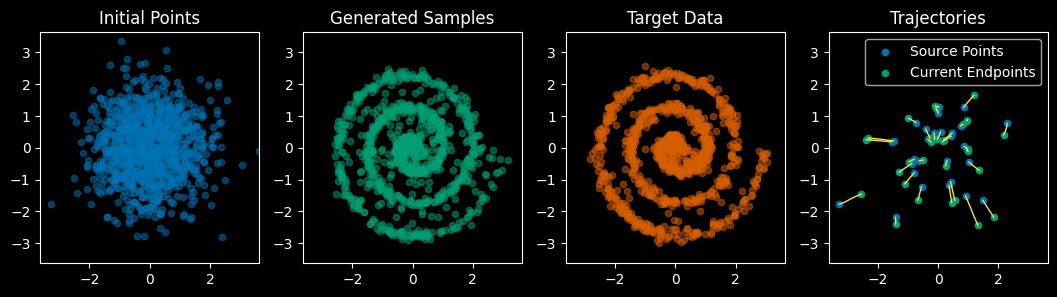

In [23]:
import copy

# Note that the student/reflow model could have a simpler architecture 
# than the teacher/pretrained model, but... we'll just keep 'em the same :shrug:
reflowed_model = copy.deepcopy(pretrained_model) # no need to start from scratch, use teacher's weights
reflowed_model.train()               # make sure we have gradients turned on

reflowed_model = train_reflow_model(reflowed_model, pretrained_model=pretrained_model)